# Burnt area mapping using Sentinel-2 data

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background

### Normalized Burn Ratio

The Normalized Burn Ratio (NBR) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to find burnt area. 
It is calculated using the following Sentinel-2 bands: Near Infrared/Band 8 and Shortwave Infrared/Band 12. The equation is defined below: 

\begin{equation}
\text{NBR} = \frac{(\text{NIR} - \text{SWIR})}{(\text{NIR} + \text{SWIR})}
\end{equation}

NBR returns values between -1 and 1. 
**Healthy green vegetation will have a high NBR value while burnt vegetation will have a low value**. 
Areas of dry, brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalized Burn Ratio

Change in Normalized Burn Ratio - also called Delta Normalized Burn Ratio (dNBR) - is calculated by subtracting the post-fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
\text{dNBR} = \text{NBR}_{\text{baseline}} - \text{NBR}_{\text{post fire}}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what is burnt as it shows change from the baseline state. 
**A burnt area will have a positive dNBR value** while an unburnt area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity). 
A higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowledge portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

### Defining Burnt From Unburnt Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropriate for differentiating burnt from unburnt areas when using Sentinel-2. 
However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

Using +0.1 as a threshold here may result in many false positives being picked up in the unburnt urban and forest areas where vegetation drying has occurred prior to the fire. 
A much more conservative threshold here of +0.3 produces a better result. 
Keep in mind the limitations of remote sensing and that in an ideal situation ground truth data collected in the location of interest would be used to assist in selecting a threshold.

Some care should also be taken when interpreting results as a number of possible false positives can return a positive dNBR result:

* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burnt
* Drying out of bright green vegetation such as grasses. 
If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burnt.


## Description

This notebook calculates the change in Normalized Burn Ratio between a baseline composite image of the pre-fire condition of a selected area and a post-fire event image, in order to find burnt area extent.
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. 
The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. 

The notebook contains the following steps:

1.  Select a location for the analysis.
2.  Define fire event date and length of composite image.
3.  Load all baseline data.
4.  Generate Normalized Burn Ratio for baseline period.
5.  Load post-fire data.
6.  Generate Normalized Burn Ratio for post fire image.
7.  Calculate Delta Normalized Burn Ratio.
8.  Apply threshold to Delta Normalized Burn Ratio.
9.  Calculate the area burnt.
10. Export results as a GeoTIFF.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import geopandas as gpd
from pyproj import Proj, transform
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `fire_date`: The event date of the fire (e.g. `'2020-01-01'`).
* `baseline_length`: To understand the effect of the fire, the analysis produces a baseline image, which is compiled from all available data over the `baseline_length` time period prior to the `fire_date`. This can be set as `'3 months'`, `'6 months'` or `'12 months'`.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers a fire in Northern Ghana.

**To run the notebook for a different area**, make sure Sentinel-2 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check both Sentinel-2A (`s2a_msil2a`) and Sentinel-2B (`s2b_msil2a`). 

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Define the area of interest
lat = 10.338
lon = -1.055
buffer = 0.1

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

### Define fire event date and length of composite image

Delta Normalized Burn Ratio produces the best result when using a post-fire image that was collected before much re-growth has occured. 
However, images collected while the fire is still active can be obscured by smoke and not show the full burn extent. 
As a result some adjustment of the fire event date entered may be needed to get the best result.

The length of the baseline period can be automatically set to `3, 6 or 12 months`

In [4]:
# Fire event date
fire_date = '2020-01-01'

# Length of baseline period
baseline_length = '3 months'

After setting the `fire_date` and `baseline_length`, the code below automatically calculates start and end dates for the pre-fire and post-fire periods.
The post-fire period is defined as 30 days after the `fire_date`.

In [5]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=1)), '%Y-%m-%d')
end_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=30)), '%Y-%m-%d')

In [6]:
# Print dates
print('start_date_pre:  '+start_date_pre)
print('end_date_pre:    '+end_date_pre)
print('fire_date:       '+fire_date)
print('start_date_post: '+start_date_post)
print('end_date_post:   '+end_date_post)

start_date_pre:  2019-10-02
end_date_pre:    2019-12-31
fire_date:       2020-01-01
start_date_post: 2020-01-02
end_date_post:   2020-01-31


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [7]:
display_map(x=lon_range, y=lat_range)

## Load all baseline data

The first step in the analysis is load Sentinel-2 data for the pre-fire period, as defined by the baseline length set above.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function.
This function will automatically mask any clouds in the dataset, and only return images where more than 60% of the pixels were classified as clear (set using `min_gooddata=0.6`).
When working with Sentinel-2, the function will also combine and sort images from both Sentinel-2A and Sentinel-2B.

> **Note**: This analysis performs calculations that use the on-ground area of each pixel. For this type of analysis, it is recommended that all data be reprojected to an equal area projection, such as [EPSG:6933](https://epsg.io/6933).
This is done below by setting the `output_crs` parameter to `"EPSG:6933"`.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [8]:
# Define load parameters
resolution = (-10, 10)
measurements = ['blue', 'green', 'red',
                'nir_1', 'swir_1', "swir_2"]
min_gooddata = 0.6

In [9]:
# Choose the Sentinel-2 products to load
products = ["s2_l2a"]

# Create a reusable query
query = {   
    "x": lon_range,
    "y": lat_range,
    "resolution": resolution,
    "measurements": measurements
}

# Since this analysis calculates pixel areas,
# set the output projection to equal area projection EPSG:6933
output_crs = "EPSG:6933"

# Load all data in basline period avalible from ARD data
baseline_ard = load_ard(dc=dc,
                        products=products,
                        time=(start_date_pre, start_date_post),
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        group_by='solar_day',
                        **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 16 out of 19 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Loading 16 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [10]:
baseline_ard

<xarray.Dataset>
Dimensions:      (time: 16, x: 1931, y: 2512)
Coordinates:
  * time         (time) datetime64[ns] 2019-10-09T10:38:14 ... 2020-01-02T10:...
  * y            (y) float64 1.324e+06 1.324e+06 ... 1.299e+06 1.299e+06
  * x            (x) float64 -1.114e+05 -1.114e+05 ... -9.216e+04 -9.214e+04
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float32 335.0 320.0 334.0 ... 786.0 827.0 860.0
    green        (time, y, x) float32 548.0 562.0 549.0 ... 1068.0 1138.0 1180.0
    red          (time, y, x) float32 374.0 357.0 348.0 ... 1368.0 1460.0 1534.0
    nir_1        (time, y, x) float32 1998.0 2216.0 2274.0 ... 1838.0 1920.0
    swir_1       (time, y, x) float32 1136.0 1143.0 1143.0 ... 3046.0 3204.0
    swir_2       (time, y, x) float32 567.0 553.0 553.0 ... 3137.0 3151.0 3311.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Generate Normalized Burn Ratio for baseline period

We now calculate the NBR values for the baseline period using the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='s2'` since we're working with Sentinel-2 data.
When using `calculate_indices` the index is added directly to the `baseline_ard` dataset.

In [11]:
# Calculate NBR for the baseline images
baseline_ard = calculate_indices(baseline_ard,
                                 index='NBR',
                                 collection='s2', 
                                 drop=False)

# Compute median using all observations in the dataset along the time axis
baseline_image = baseline_ard.median(dim='time')

# Select NBR
baseline_NBR = baseline_image.NBR

### Visualise NBR

To see how NBR corresponds with a standard image, we can plot the baseline NBR data side-by-side with an RGB plot of the study area:

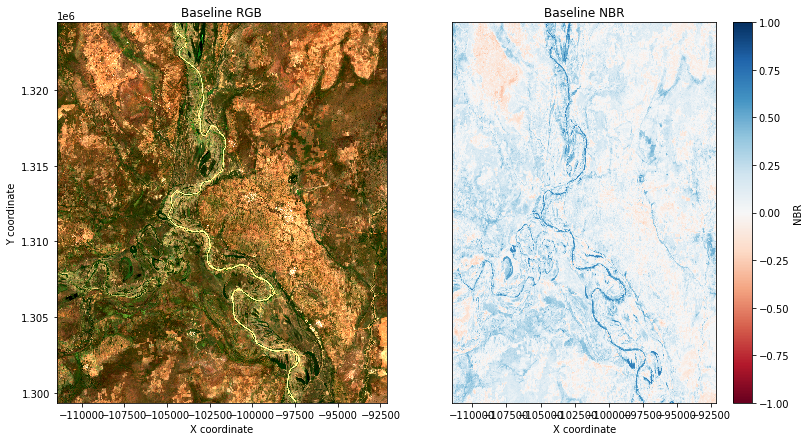

In [12]:
# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise baseline image as true colour image
rgb(baseline_image, 
    bands=['red', 'green', 'blue'], 
    ax=ax1)
ax1.set_title('Baseline RGB')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Baseline NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()

## Load post-fire data

We now load images that occur up to 30 days after the fire.
Since we previously defined the area of interest and measurements with the `query` parameter, we can reuse this to simplify the load command, noting that we only need to change the `time` variable to use the post-fire dates calculated earlier.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [ ]:
# Load post-fire NRT data from Sentinel-2A and 2B
post_col =  load_ard(dc=dc,
                     products=products,
                     time=(start_date_post, end_date_post),
                     min_gooddata=min_gooddata,
                     output_crs=output_crs,
                     group_by='solar_day',
                     **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 5 out of 6 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Loading 5 time steps


### Generate Normalized Burn Ratio for post fire image

The code in the next cell calculates the NBR for the first image in the post-fire dataset.
If the image is very cloudy, try a different image by changing the index in `post_col.isel(time=0)`.
> **Note**: the maximum value for the index is determined by how many images you loaded. 
Check the number of time steps listed above in the `load_ard` output for the post-fire dataset.
Python counts from 0, so the maximum index you can use will be one fewer than the number of time steps.

While the first image will give you an immediate picture of the landscape close to post-fire event, you could also generate the median image from the 30-day post-fire period using the code below. 
If using this, comment the code for the single image and then copy and paste the code for the median image into the cell below.

**Median**
```
# Calculate NBR on all post-fire images
post_combined = calculate_indices(post_col, index='NBR', collection='ga_s2_1', drop=False)

# Calculate the median post-fire image
post_image = post_combined.median(dim='time')

# Select NBR
post_NBR = post_image.NBR
post_NBR
```

In [ ]:
### Use a single image:

# Select the most recent image after the fire
post_image = post_col.isel(time=0)

# Calculate NBR
post_image = calculate_indices(post_image, index='NBR', collection='s2', drop=False)

# Select NBR
post_NBR = post_image.NBR

### MODIS and VIIRS hotspot data

The Fire information for Resource Management System ([FIRMS](https://firms.modaps.eosdis.nasa.gov/)) distributes hotspots observed from satellites for near real time (NRT) active fires and historical fires. The hotspot information is generated from both the Moderate Resolution Imaging Spectroradiometer (MODIS) and the Visible Infrared Imaging Radiometer Suite (VIIRS).

Here, the hotspots data from FIRMS is used to analyse the changes in NBR at the locations identified as active (or historical) fire. To obtain the data from FIRMS, a new request can be created on the [Archive Download](https://firms.modaps.eosdis.nasa.gov/download/) webpage. It is possible to specify the region and dates of interest for the hotspots information. Once the processing of request has been completed, shapefiles containing data from MODIS C6 and VIIRS will be available for download. The hotspots files for MODIS and VIIRS are processed separately.

As the region used for requesting hotspots can be different from the region used to process Sentinel-2 data, following two steps can be done either offline or within the notebook. The aforementioned two pre-processing steps are:

* Clip hotspots data for (`lon_range, lat_range`)
* Merge hotspot information from MODIS and VIIRS

After clipping and merging the hotspots information, open the hotspots shapefile using the next cell:

In [ ]:
# Extract contents of zip file

with ZipFile('../Supplementary_data/Burnt_area_mapping/fire_hotspots.zip') as spots:
    spots.extractall(path="../Supplementary_data/Burnt_area_mapping")

The next cell projects hotspots from the source projection (`"EPSG:4326"`) to the projection we're using for Sentinel-2 data (`EPSG:6933`). Here, we have used proj4 to transform hotspot locations from source to a desired projection.

In [ ]:
# Read shapefile into a geopandas GeoDataFrame

fire_hotspots = gpd.read_file("../Supplementary_data/Burnt_area_mapping/fire_hotspots/clip_merged.shp")

# Extract the location of hotspots from the GeoDataFrame into a numpy.ndarray
spot_locs = fire_hotspots.to_crs(epsg=6933)
spot_locs = np.array([[item.x, item.y] for item in spot_locs.geometry.to_list()])

### Examine hotspots

The next cell plots the FIRMS hotspots on top of the post-fire NBR image, and plots the baseline NBR image alongside. 
This allows for direct comparison of the NBR values before and after the fire, as well as how hotspots spatially correlate with areas that register as burnt after the fire.
Hotspots are shown as black squares in the second image.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Baseline NBR')
ax1.yaxis.set_visible(False)
ax1.set_xlabel('X coordinate')

# Visualise post-fire image as NBR image and overplot hotspots
post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.plot(spot_locs[:,0], spot_locs[:,1], marker='s',
       linestyle='', mfc='None', mec='k', mew=1.5)
ax2.set_title('Post-fire NBR with MODIS Hotspots')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate');

### Extract data at the FIRMS hotspots for baseline NBR and post-fire NBR

The next step is to extract the NBR values at the hotspot locations; doing this for the baseline and post-fire NBR images allows us to examine how the fire has influenced the NBR values.

To extract data, we use the `xarray.DataArray.sel` method, which returns a two dimensional array. This in artefact of how we specified the coordinates of the hotspot locations, which are one dimensional numpy array. The values along the diagonal of the returned two dimensional array correspond to the hotspot locations which can be obtained using `np.diagonal` method.

In [ ]:
point_nbr = {}

# Extract baseline NBR at hotspot locations
point_nbr["baseline"] = np.diagonal(baseline_NBR.sel(x=spot_locs[:,0],
                                                     y=spot_locs[:,1], 
                                                     method='nearest'))

# Extract post-fire NBR at hotspot locations
point_nbr["post"] = np.diagonal(post_NBR.sel(x=spot_locs[:,0],
                                             y=spot_locs[:,1],
                                             method='nearest'))

Using the extracted data, we can make a box-plot of NBR obtained from baseline and post-fire datasets for all the hotspot locations.

In [ ]:
ax = pd.DataFrame(point_nbr).boxplot(figsize=(10, 6), whis=0.75,
                                     patch_artist=True,
                                     vert=True, fontsize=14,
                                     return_type='both')

ax[0].set_ylabel("NBR", fontsize=14)
ax[0].set_title("NBR at FIRMS Hotspots", fontsize=14);
ax[0].set_xticklabels(["baseline", "post-fire"])
ax[0].grid(False)

colors = ['#addd8e', '#fdbb84']

for patch, color in zip(ax[1]['boxes'], colors):
    patch.set_facecolor(color)

Here, we can notice that the post-fire NBR decreases from the baseline NBR at the hotspots, consistent with those locations having been affected by the fire.

We can also compare the change in NBR over the course of three months at the hotspots. To that end, we will use `xarray` method to extract the data the hotspot locations.
To do this, we also extact cleaned versions of the dates of the baseline observations.

In [ ]:
# Get cleaned baseline observation dates
baseline_ard['time'] = baseline_ard.indexes['time'].normalize()
dates = (pd.to_datetime((baseline_ard.time).values)).strftime('%Y-%m-%d')

# Get the baseline NBR value for each image at all hotspots
baseline_nbr_spot = baseline_ard.NBR.sel(x=spot_locs[:,0],
                                         y=spot_locs[:,1],
                                         method='nearest')

nbr_over_time = {}
for i in range(len(dates)):
    nbr_over_time[dates[i]] = np.diagonal(baseline_nbr_spot[i,:,:])
nbr_over_time = pd.DataFrame(nbr_over_time)

# Create a box plot for each observation
ax = nbr_over_time.boxplot(figsize=(16, 4), whis=0.75,
                           patch_artist=True,
                           vert=True, return_type='both')
ax[0].set_ylabel("NBR", fontsize=14)
ax[0].set_title("NBR at MODIS Hotspots", fontsize=14);
ax[0].grid(False)

# Colour the boxes by the mean NBR of each observation
cm = plt.cm.get_cmap("Blues", len(nbr_over_time.index))
colors = [cm(item.get_ydata().mean()) for item in ax[1]['medians']]
for patch, color in zip(ax[1]['boxes'], colors):
    patch.set_facecolor(color)
ax[0].tick_params(axis='x', rotation=45)

After plotting the change in NBR over a period of three months, we can notice that there is sharp drop in NBR between 
October 2019 and November 2019, however, there is little to no change between November 2019 to January 2020.

Finally, we plot the post-fire NBR data side-by-side with an RGB plot of the study area:

In [ ]:
# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# Visualise post-fire image as true colour image
rgb(post_image, 
    bands=['red', 'green', 'blue'], 
    ax=ax1)
ax1.set_title('Post-fire RGB')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Post-fire NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()

## Calculate Delta Normalized Burn Ratio
We can now compute delta NBR by subtracting our post-fire NBR data from our baseline NBR data:

In [ ]:
delta_NBR = baseline_NBR - post_NBR

# Visualise dNBR image
delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.show()

### Apply threshold to Delta Normalized Burn Ratio

We now apply the dNBR threshold value to try and reduce false positives, only keeping areas with dNBR values greater than the chosen threshold value of 0.3.
The chosen threshold value may need to be adjusted depending on the use case.

In [ ]:
# Set threshold
threshold = 0.3

# Apply threshold
burnt = delta_NBR > threshold

# Mask post-fire true colour image
masked = delta_NBR.where(burnt==1)

Re-visualize pre and post-fire true colour images to help adjust the NBR threshold:

In [ ]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['red', 'green', 'blue']

baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

delta_NBR.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(baseline_image, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(post_image, bands=bands, ax=axarr[1,1])
axarr[1, 1].set_title('Post-fire RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

rgb(post_image.where(burnt==1), bands=bands, ax=axarr[1, 2])
axarr[1, 2].set_title('Burnt RGB')
axarr[1, 2].set_xlabel('X coordinate')
axarr[1, 2].yaxis.set_visible(False)

## Calculate area burnt

The next cell uses the resolution of Sentinel-2 pixels to estimate the amount of area burnt, defined as those areas with dNBR values greater than the set threshold.
A number of other statistics are calculated, accounting for areas that have no data.

In [ ]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (delta_NBR <= threshold).sum() * area_per_pixel
burnt_area = burnt.sum() * area_per_pixel
not_nan_area = delta_NBR.notnull().sum() * area_per_pixel
nan_area = delta_NBR.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')
print()
print(f'Percentage of total area burnt: {100*burnt_area.item()/total_area.item():.2f}%')

## Export results to GeoTIFF

The baseline reference image and the post fire image will both be saved as a multiband GeoTIFF with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The thresholded burnt area image will be saved as a single band image, where a value of 1 = burnt and a value of 0 = not burnt.

In [ ]:
# # Define an area name to be used in saved file names
# area_name = 'Example'

# # Write baseline reference image to multi-band GeoTIFF
# write_cog(baseline_image.to_array(), f'{area_name}_baseline_image.tif')

# # Write post fire image to multi-band GeoTIFF
# write_cog(post_image.to_array(), f'{area_name}_post_fire_image.tif')

# # Turn delta NBR into a Xarray Dataset for export to GeoTIFF
# dnbr_dataset = delta_NBR.to_dataset(name='burnt_area')
# write_cog(dnbr_dataset.to_array(), f'{area_name}_delta_NBR.tif')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')